In [217]:
# General
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn import metrics
import re
from collections import Counter
import itertools
from itertools import cycle
import time

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from plotnine import *

# Feature engineering
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Modeling
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import ensemble
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from __future__ import print_function

February 2019 <br>
Nadine Ruecker 
# Challenge: Build your own NLP model - Lyrics

For this challenge, you will need to choose a corpus of data from nltk or another source that includes categories you can predict and create an analysis pipeline that includes the following steps:

Data cleaning <br> processing <br> language parsing
Create features using two different NLP methods: For example, BoW vs tf-idf.<br>
Use the features to fit supervised learning models for each feature set to predict the category outcomes.<br>
Assess your models using cross-validation and determine whether one model performed better.<br>
Pick one of the models and try to increase accuracy by at least 5 percentage points.<br>
<br>
Write up your report in a Jupyter notebook. Be sure to explicitly justify the choices you make throughout, and submit it below.<br>
<br>
Data: https://www.kaggle.com/mousehead/songlyrics#songdata.csv
# Aims

I would like to compare the content of song texts and see if against my assumptions NLP is able to predict the artist based on a sentence in a song text. This is not a truly valuable application, because a simple database search could do that job, but this could be applied to other shorter text, for example news articles or scientific publication. Here, the detection of the predicted author is interesting in regards to plagrism. More sophisticated versions, could also be used for content extraction/classification of books for recommendations. Songtexts are also particular, because of the way content is repeated or very similar during refrains for example, which might lead to an overestimation in accuracy.<br>
This is not an analysis that trys to compare the music, as features like beats per minute ar absent from the dataset. This an analysis solely based on texts.

# Summary

The dataset is very rich. In order to keep the actual run time of calculation moderate, I selected the 5 artist, each represented with around 180 songs.<br>
Initially I planned to use bag-of-words, tfidf and part-of-speech for feature generation, but I drop bag-of words, because of run time duration. Feature engineering for modeling was performed on sentence level.<br>
The best model to differentiate Bob Dylan's songs from other artists was logistic regression, which was only marginally improved using a grid search with several parameters for alpha in LASSO or Ridge regression. <br>
The distribution of sentences in the n-dimensional space was evaluated using clustering. To determine the actuall accuracy of clusters silhouette score measures were used, which indicated that the clusters strongly overlap, which intuively makes alot of sense. As the modeling only aimed to differentiate Dylan songs from other artists, the modeling might actually be an overestimation. We can see that sentences actually do cluster even in 2d. Therefore, it can be assumed that the modeling accruary for other artists would have been much lower.<br>
Three similarity matrices were chosen to evalualte the similarity of whole song texts, with the aim of clustering song texts that cover similar topic. Jaccard and cosine similarity similarity are able to detect partial duplicates, but their answers diverge on songs when no duplicate is included.<br>
The distribution of song texts in the n-dimensional space based on their tfidf svd-components, was further evaluated using clustering. Again the tfidf-svd features of the complete texts still overlap.<br>
My analysis is only preliminary and could be improved in multilple ways, but this would supercede the scope of this assignment. The prediction accuracy should be evaluated for all other authors and accuracy could probably be improved by tweaking the parameters of the tfidfvectorizer. Using different models like suport vector machines or naive bayes would be intresting as we. The clustering algorithm choice was not suited for the cluster shape and variance.
# Explore data

In [2]:
songs = pd.read_csv('Songtexts\songdata.csv')
print(songs.shape)
songs.head()

(57650, 4)


,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [3]:
artists = songs.groupby(['artist']).nunique()
artists['Band']=artists.index
artists.head()

,artist,song,link,text,Band
artist,,,,,
'n Sync,1,93,93,93,'n Sync
ABBA,1,113,113,113,ABBA
Ace Of Base,1,74,74,74,Ace Of Base
Adam Sandler,1,70,70,70,Adam Sandler
Adele,1,54,54,54,Adele


In [4]:
print( 'Number of artists with more than 100 texts: ', len(artists.Band[artists.song>100]))
artists=artists.sort_values('song',ascending =False )
artists.head(10)

Number of artists with more than 100 texts:  268


,artist,song,link,text,Band
artist,,,,,
Donna Summer,1,191,191,191,Donna Summer
Gordon Lightfoot,1,189,189,189,Gordon Lightfoot
Bob Dylan,1,188,188,188,Bob Dylan
George Strait,1,188,188,188,George Strait
Cher,1,187,187,186,Cher
Alabama,1,187,187,187,Alabama
Reba Mcentire,1,187,187,187,Reba Mcentire
Loretta Lynn,1,187,187,187,Loretta Lynn
Dean Martin,1,186,186,186,Dean Martin


In [5]:
# Select the 5 artists with most of the songs
chosenartists=artists.index[0:5]

df=songs[songs['artist'].isin(chosenartists)]
print(df.shape)

# How long are the texts on average per artist?
wordcounts=[]
for i, text in enumerate(df['text']):
    wordcounts.append(len(text))
df['wordcounts']=wordcounts
df.head()

(943, 4)


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,artist,song,link,text,wordcounts
1576,Bob Dylan,4Th Time Around,/b/bob+dylan/4th+time+around_20021421.html,"When she said, ""Don't waste your words, they'r...",1435
1577,Bob Dylan,A Satisfied Mind,/b/bob+dylan/a+satisfied+mind_20021501.html,How many times have you heard someone say \nI...,610
1578,Bob Dylan,Ain't Gonna Grieve,/b/bob+dylan/aint+gonna+grieve_20275479.html,"By Bob Dylan \n \nWell, I ain't a-gonna grie...",1478
1579,Bob Dylan,All Over You,/b/bob+dylan/all+over+you_20238880.html,"By Bob Dylan \n \nWell, if I had to do it al...",2029
1580,Bob Dylan,Ballad Of Donald White,/b/bob+dylan/ballad+of+donald+white_20155910.html,"My name is Donald White, you see, \nI stand b...",2504


In [6]:
overview= df.groupby('artist').agg({'wordcounts':{'Mean':'mean','Max:': 'max','Min:':'min', 'Total':'sum'}})
overview

wordcounts                   
                         Mean  Max: Min:   Total
artist                                          
Bob Dylan         1384.382979  3988  449  260264
Cher              1044.663102  2918  421  195352
Donna Summer      1240.356021  2805  427  236908
George Strait      934.047872  2147  456  175601
Gordon Lightfoot  1218.925926  2963  432  230377

Text(0.5, 1.0, 'Song text length by artist')

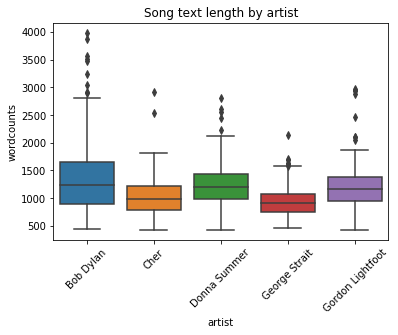

In [7]:
# plot the average song text word count
sns.boxplot(data=df,x='artist',y='wordcounts')
plt.xticks(rotation=45)
plt.title('Song text length by artist')

# Analysis on sentence level
## Functions

In [8]:
# Tokenization of document
def bag_of_words(text, NumberOfWordsToReturn):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(NumberOfWordsToReturn)]

In [9]:
# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [10]:
def pos_features(sentences):
    
    possiblePOS=['POS','ADJ','ADP','ADV','AUX','CONJ','CCONJ','DET','INTJ','NOUN','NUM',
             'PART','PRON','PROPN','PUNCT','SCONJ','SYM','VERB','X','SPACE']
    df_sent = pd.DataFrame(sentences)
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=possiblePOS)
    df['text_sentence'] = df_sent[0]
    df['text_source'] = df_sent[1]
    df.loc[:, possiblePOS] = 0
    
    # Process each row, counting the occurrence of POS in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        # Convert the sentence to doc and then extract all pos
        str_sent = str(sentence)
        doc = nlp(str_sent)
        for token in enumerate(doc):
            #print('token: ',token[1])
            #print('token_pos: ',token[1].pos_)
            poss = [token.pos_ for token in doc]
        
        # Populate the row with pos counts.
        for pos in poss:
            df.loc[i, pos] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
    # replace all NaN with 0  
    df=df.fillna(0) 

    # some more features
    df['NounsNonNounsRatio']=df['NOUN']/df.sum(axis=1)
    df['NounsVerbsRatio']=df['NOUN']/(df['NOUN']+df['VERB'])
    df['ADJ+ADVRatio'] = (df['ADJ']+df['ADV'])/df.sum(axis=1)
    
    # Fix some issues of the df
    df=df.fillna(0) # replace all NaN with 0
    return df

In [188]:
#Function for tfidf with SVD

def runTFiDFandSVD(text_paras,maxdf,mindf,ncomps):
    vectorizer = TfidfVectorizer(max_df=maxdf, # drop words that occur in more than 75% of all the paragraphs
                                 min_df=mindf, # only use words that appear at 4 times
                                 stop_words='english', 
                                 lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                                 use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                                 norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                                 smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                                )

    X_train, X_test = train_test_split(text_paras, test_size=0.4, random_state=0)
    
    #Applying the vectorizer
    text_paras_tfidf=vectorizer.fit_transform(text_paras)
    print("Number of features: %d" % text_paras_tfidf.get_shape()[1])

    #Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
    svd= TruncatedSVD(ncomps)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    # Run SVD on the training data, then project the training data.
    svd_lsa = lsa.fit_transform(text_paras_tfidf)

    variance_explained=svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    print("Percent variance captured by all components:",total_variance*100)

    #Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
    paras_by_component=pd.DataFrame(svd_lsa,index=text_paras)
    for i in range(5):
        print('Component {}:'.format(i))
        print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])
    
    results=pd.DataFrame()
    results['svd']=range(ncomps)
    results['variance']=svd.explained_variance_ratio_
    results=results.sort_values('variance',ascending=False)
    print(results.head())
        
    return(text_paras_tfidf, paras_by_component, results)

## Generate features
### Generate bag of words for authors

In order to determine the characteristic words used by an author, I will combine all song texts by artist, extract the most common 2000 words. Combine the most common words of all authors, erase duplicates and later run the bag of words methods on the set of the most common words to extract the bag of words features.

In [219]:
# Combine all texts functions
# alltexts is a list, each element of the list is all songtexts from one artist
alltexts=[]
for artist in df.artist.unique():
    print(artist)
    artist_data= df[df['artist']==artist]
    alltexts.append(artist_data['text'].str.cat(sep=" \n"))
print(len(alltexts))

Bob Dylan
Cher
Donna Summer
George Strait
Gordon Lightfoot
5


In [220]:
# Parse the songtexts using spacy tokenization. This can take a bit.
nlp = spacy.load('en')

# tokenize
Dylan_doc = nlp(alltexts[0])
Cher_doc = nlp(alltexts[1])
Summer_doc = nlp(alltexts[2])
Strait_doc = nlp(alltexts[3])
Lightfoot_doc = nlp(alltexts[4])

In [221]:
# Extact the 2000 most common words
Dylanwords= bag_of_words(Dylan_doc, 2000)
Cherwords= bag_of_words(Cher_doc,2000)
Summerwords= bag_of_words(Summer_doc,2000)
Straitwords= bag_of_words(Strait_doc,2000)
Lightfootwords= bag_of_words(Lightfoot_doc,2000)

# Combine the most common words
commonwords=set(Dylanwords + Cherwords + Summerwords + Straitwords + Lightfootwords)
print('Number of most common words:',len(commonwords))

Number of most common words: 4776


In [223]:
# Group into sentences.
Dylan_sents = [[sent, "Dylan"] for sent in Dylan_doc.sents]
Cher_sents = [[sent, "Cher"] for sent in Cher_doc.sents]
Summer_sents = [[sent, "Summer"] for sent in Summer_doc.sents]
Strait_sents = [[sent, 'Strait'] for sent in Strait_doc.sents]
Lightfoot_sents =[[sent, 'Lightfoot'] for sent in Lightfoot_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(Dylan_sents + Cher_sents + Summer_sents + Strait_sents + Lightfoot_sents)
print(sentences.shape)
sentences.head()

(16273, 2)


,0,1
0,"(When, she, said, ,, "", Do, n't, waste, your, ...",Dylan
1,"(And, she, worked, on, my, face, until, breaki...",Dylan
2,"(It, was, then, that, I, got, up, to, leave, \n)",Dylan
3,"(But, she, said, ,, "", Do, n't, forget, ,, \n...",Dylan
4,"(I, stood, there, and, hummed, ,, \n, I, tapp...",Dylan


Running bow_features on my computer would probably take 5-6 days... That is too long.

In [18]:
# Create our data frame with features. This can take a while to run.
#word_counts = bow_features(sentences, commonwords)
#word_counts.head()

### Part of speech features

In [123]:
### Extract part of speech features
Dylan_pos=pos_features(Dylan_sents)
Cher_pos_features= pos_features(Cher_sents)
Summer_pos_features= pos_features(Summer_sents)
Strait_pos_features= pos_features(Strait_sents)
Lightfoot_pos_features= pos_features(Lightfoot_sents)

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500


In [20]:
# 1. Combine the POS_dfs
POS_both = Dylan_pos.append(pd.DataFrame(data = Cher_pos_features), ignore_index=True)
print('2:',POS_both.shape)
POS_three= POS_both.append(pd.DataFrame(data=Summer_pos_features),ignore_index=True)
print('3:',POS_three.shape)
POS_four= POS_three.append(pd.DataFrame(data=Strait_pos_features),ignore_index=True)
print('4:',POS_four.shape)
POS_five= POS_four.append(pd.DataFrame(data=Lightfoot_pos_features),ignore_index=True)
print('5:',POS_five.shape)

2: (6964, 25)
3: (10650, 25)
4: (13448, 25)
5: (16273, 25)


### Tfidf features

In [224]:
sentences_only= sentences[0].tolist()
sentences_only = [str(item) for item in sentences_only]
print(type(sentences_only))
print(type(sentences_only[0]))

<class 'list'>
<class 'str'>


In [227]:
tfidf,svd,svdresults= runTFiDFandSVD(sentences_only,0.5,10,200)

Number of features: 1290
Percent variance captured by all components: 54.76659438439903
Component 0:
Only love would know, only love would do  \n                                                                                     0.790241
I found you love  \nWith greg allman  \nWriter alan gordon  \n  \n                                                               0.739333
And there's only love and fear  \n  \n                                                                                           0.738763
Your love, your love, your love  \n                                                                                              0.738641
I do love you  \n                                                                                                                0.738641
I love                                                                                                                           0.738641
I love                                                                 

### Combine Features

In [228]:
# Column bind svd on index with POS_five
svda=svd.reset_index()
svda= svda.drop('index', axis=1)
svd_pos = pd.concat([svda, POS_five], axis=1)
print(svd_pos.shape)

(16273, 225)


# Modeling
To predict the artist based on a sentence from a song, the tfidf-svd non-sparse matrix in combination with the pos-features will be used.

## Functions

In [28]:
def CheckSenandSpe(Name,model,input_df,target,no_folds):
    y_pred = cross_val_predict(model,input_df,target,cv=no_folds)
    tn, fp, fn, tp = confusion_matrix(target,y_pred).ravel()
    
    print(Name)
    print()
    print('True Positives:',tp)
    print('False Negatives:',fn)
    
    Sensitivity=tp/(tp+fn)*100
    print('Sensitivity:',round(tp/(tp+fn)*100,3))
    print()
    print('True Negatives:',tn)
   
    print('False Positives:',fp)
    Specificity=tn/(tn+fp)*100
    print('Specificity:',round(tn/(tn+fp)*100))
    
    return(Sensitivity,Specificity)

In [29]:
def runRFC_class(input_df, target, no_folds):
    start_time=time.time()
    rand_forest_class = ensemble.RandomForestClassifier()
    rand_forest_class.fit(input_df, target)
    print('Random Forest')
    #print('Feature Importance:{}',rand_forest_class.feature_importances_)
    cvs = cross_val_score(rand_forest_class, input_df, target, cv=no_folds)    
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy RFC: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()
    print(CheckSenandSpe('RFC - Sensitivity and Specificity',rand_forest_class,input_df,target,no_folds))
    print()
    return(cvs)

In [30]:
def runKNN_class(input_df, target,numNeigh, no_folds):
    start_time=time.time()
    knn_w = neighbors.KNeighborsClassifier(n_neighbors=numNeigh, weights='distance')
    cvs = cross_val_score(knn_w, input_df, target, cv=no_folds)
    print('KNN')
    # cross validation
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy KNN with weights: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()
    print(CheckSenandSpe('KNN - Sensitivity and Specificity',knn_w,input_df,target,no_folds))
    print()
    return(cvs)

In [229]:
def runLogit(input_df,target,no_folds):
    start_time=time.time()

    logreg = linear_model.LogisticRegression()
    
    logreg.fit(input_df, target)
    print('Logistic regression')
    #print('Coefficients Log Regression:',logreg.coef_)
      
    cvs = cross_val_score(logreg, input_df, target, cv=no_folds)

    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()
    print(CheckSenandSpe('Logit - Sensitivity and Specificity',logreg,input_df,target,no_folds))
    print()
    return(cvs)

In [32]:
def runMLP(input_df,target,no_folds,l1,l2,l3,l4): 
    #284,100,50,10
    start_time= time.time()
    print('Multilayerd perceptron')
    mlp = MLPClassifier(hidden_layer_sizes=(l1,l2,l3,l4))  
    cvs=cross_val_score(mlp, input_df,target, cv=no_folds)
    print('Time taken: {} minutes.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy RFC: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    runtime=time.time() - start_time
    print()
    print(CheckSenandSpe('MLP - Sensitivity and Specificity',mlp,input_df,target,no_folds))
    return(cvs)

## 1st attempt - Identify a Bob Dylan Song

I'm using the tfidf-svd non-sparse matrix in combination with the pos-features for the modeling.

In [272]:
# prepare the data to predict Dylan: tfidf-svd
dylan_svd_pos=svd_pos
print(dylan_svd_pos.text_source.unique())
mask = dylan_svd_pos.text_source != 'Dylan'
dylan_svd_pos.loc[mask, 'text_source'] = 'other'
print(dylan_svd_pos.text_source.unique())

# Define X and Y
X_svdpos=dylan_svd_pos.drop(['text_source','text_sentence'], axis=1)
Y_svdpos=dylan_svd_pos['text_source']

['Dylan' 'other']
['Dylan' 'other']


In [231]:
#tfidf
input_df=X_svdpos
target=Y_svdpos
no_folds=5
numNeigh=4
l1,l2,l3,l4 = (500,100,20,4)

In [232]:
cvs_RFC_svdpos= runRFC_class(input_df, target, no_folds)

Random Forest
Time taken: 17.245 seconds.
Average accuracy RFC: 0.734
Standard deviation of accuracy: 0.028

RFC - Sensitivity and Specificity

True Positives: 10893
False Negatives: 1471
Sensitivity: 88.103

True Negatives: 1064
False Positives: 2845
Specificity: 27.0
(88.10255580718214, 27.219237656689693)



In [233]:
cvs_KNN_svdpos = runKNN_class(input_df, target,numNeigh, no_folds)

KNN
Time taken: 44.985 seconds.
Average accuracy KNN with weights: 0.727
Standard deviation of accuracy: 0.020

KNN - Sensitivity and Specificity

True Positives: 10602
False Negatives: 1762
Sensitivity: 85.749

True Negatives: 1235
False Positives: 2674
Specificity: 32.0
(85.74894856033646, 31.593757994371963)



In [234]:
cvs_logit_svdpos = runLogit(input_df,target,no_folds)

Logistic regression
Time taken: 10.229 seconds.
Average accuracy: 0.776
Standard deviation of accuracy: 0.023

Logit - Sensitivity and Specificity

True Positives: 11554
False Negatives: 810
Sensitivity: 93.449

True Negatives: 1070
False Positives: 2839
Specificity: 27.0
(93.44872209640893, 27.372729598362756)



In [235]:
cvs_MLP_svdpos = runMLP(input_df,target,no_folds,l1,l2,l3,l4)

Multilayerd perceptron
Time taken: 134.790 minutes.
Average accuracy RFC: 0.720
Standard deviation of accuracy: 0.035

MLP - Sensitivity and Specificity

True Positives: 10871
False Negatives: 1493
Sensitivity: 87.925

True Negatives: 983
False Positives: 2926
Specificity: 25.0
(87.92461986412164, 25.14709644410335)


Text(0.5, 0, 'Models tried')

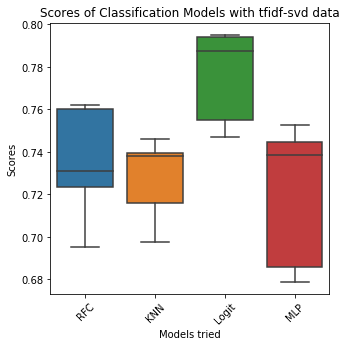

In [237]:
Scores = {'RFC': cvs_RFC_svdpos,'KNN':cvs_KNN_svdpos, 'Logit':cvs_logit_svdpos,'MLP':cvs_MLP_svdpos}
Scoreresults = pd.DataFrame(data=Scores, index=(range(no_folds)))

# Make a boxplot for comparison
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
im = sns.boxplot(data=Scoreresults[Scoreresults.columns], ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45)
im.set_title('Scores of Classification Models with tfidf-svd data')
im.set_ylabel('Scores')
im.set_xlabel('Models tried')

Logistic regression shows the highest mean accuracy.
Let's see if we can optimize the logistic regression using LASSO or Ridge.

## Logistic regression with LASSO and Ridge

In [238]:
# Use Grid search to fit best lasso
param_grid = {'C': [ 0.1,0.5, 1,2,5, 10,100]}

input_df=X_svdpos
target=Y_svdpos

X_train, X_test, Y_train, Y_test= train_test_split(input_df, target, test_size=0.33, random_state=0)

In [240]:
logreg = linear_model.LogisticRegression(penalty='l1')
CV_model_l1 = GridSearchCV(estimator=logreg, param_grid=param_grid, cv= 5)

CV_model_l1.fit(X_train, Y_train)
conf=CV_model_l1.predict_proba(X_test)
confusion=conf.mean(axis=0)
print('Specificity and Sensitivity l1 :',confusion)
accuracy_l1 = np.mean(Y_test == CV_model_l1.predict(X_test))

std_l1 = np.std(Y_test == CV_model_l1.predict(X_test))
print("Accuracy of ", round(accuracy_l1,3)," with an error of:",round(std_l1,3))
print("Best parameters:", CV_model_l1.best_params_)  #Get parameters for this estimator.

Specificity and Sensitivity l1 : [0.24002999 0.75997001]
Accuracy of  0.807  with an error of: 0.394
Best parameters: {'C': 1}


In [241]:
logreg2 = linear_model.LogisticRegression(penalty='l2')
CV_model_l2 = GridSearchCV(estimator=logreg2, param_grid=param_grid, cv= 5)

CV_model_l2.fit(X_train, Y_train)
conf=CV_model_l2.predict_proba(X_test)
confusion=conf.mean(axis=0)
print('Specificity and Sensitivity :',confusion)
accuracy_l2 = np.mean(Y_test == CV_model_l2.predict(X_test))
std_l2 = np.std(Y_test == CV_model_l2.predict(X_test))
print("Accuracy of ", round(accuracy_l2,3)," with an error of:",round(std_l2,3))
print("Best parameters:", CV_model_l2.best_params_)  #Get parameters for this estimator.

Specificity and Sensitivity : [0.23946688 0.76053312]
Accuracy of  0.808  with an error of: 0.394
Best parameters: {'C': 100}


## Modeling results

Against my assumption, NLP is able to differentiate Dylan songs from 5 other artists. Of course, this is not really a relevant application, because it can simply be replaced by a database search. The model was not significantly optimized using LASSO or Ridge regression, those methods seem to overfit as the standard error is almost 10 bigger than for the regular logistic regression.



# Do the sentences cluster by author?
Clustering based on tfidf-svd data, generated based on sentence level.
When comparing 5 artists (~1200 song texts, ~16200 sentences), how many clusters will we find? The graph might be misleading, as the first and second svd-components together only represent around 3% of the variance. But in general the data looks not radially symmetrical, therefore KMeans might not be the best clustering choices. Other clustering algorithms that might fit the data better, like SpectralClustering of Gaussian mixture, however can not be used to calculate the silhouette score. 

In [245]:
#prepare the tfid-svd data
svdn=svd.reset_index()
svdn= svdn.drop('index',axis=1)
# Get columns names

# Add columns names
n_lsa=svdn.shape[1]

columnsN=[]
for i in range(n_lsa):
    columnsN.append('lsa_'+str(i+1))

svdn.columns=columnsN

#
sentencesn=sentences.reset_index()
svd_df = pd.concat([svdn, sentencesn], axis=1)


svd_df.drop('index', axis=1)

svd_df.columns=svd_df.columns.astype('str')


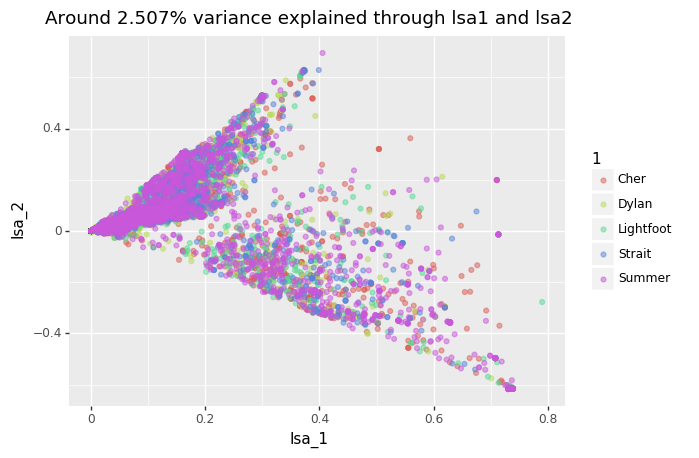

<ggplot: (148738330134)>

In [244]:
expVar12=round((svdresults.variance.iloc[0]+svdresults.variance.iloc[1])*100,3)
Title='Around '+ str(expVar12) +'% variance explained through lsa1 and lsa2'
(ggplot(svd_df)
 + geom_point(aes(x='lsa_1', y='lsa_2', color='1'), alpha = 0.5)
 + labs(title=Title)
)

For n_clusters = 3 The average silhouette_score is : 0.030412795499108733
For n_clusters = 4 The average silhouette_score is : 0.03520648299973223
For n_clusters = 5 The average silhouette_score is : 0.041763357458910556
For n_clusters = 6 The average silhouette_score is : 0.04592334247343625
For n_clusters = 7 The average silhouette_score is : 0.0506750161471269
For n_clusters = 8 The average silhouette_score is : 0.05348910238796689
For n_clusters = 9 The average silhouette_score is : 0.056959033192483285
For n_clusters = 10 The average silhouette_score is : 0.05923144260781194
For n_clusters = 20 The average silhouette_score is : 0.07626348125557932
For n_clusters = 30 The average silhouette_score is : 0.08774811934625802


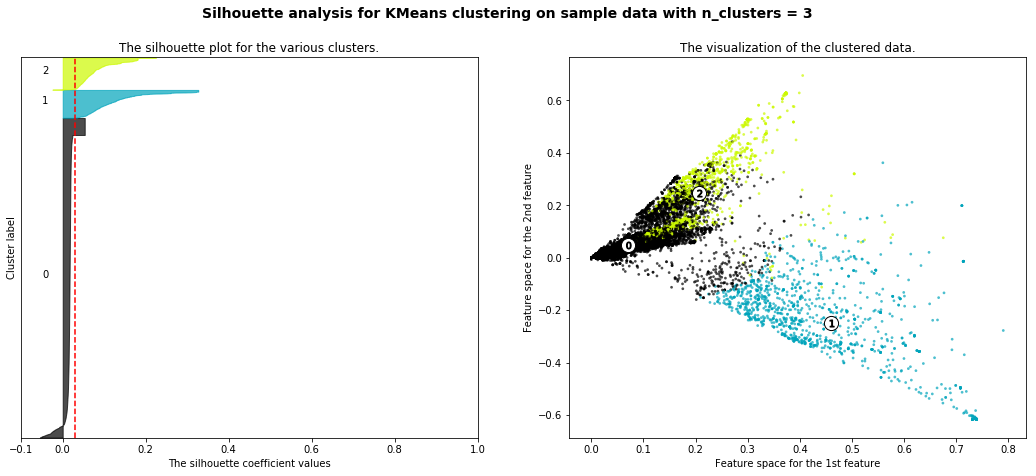

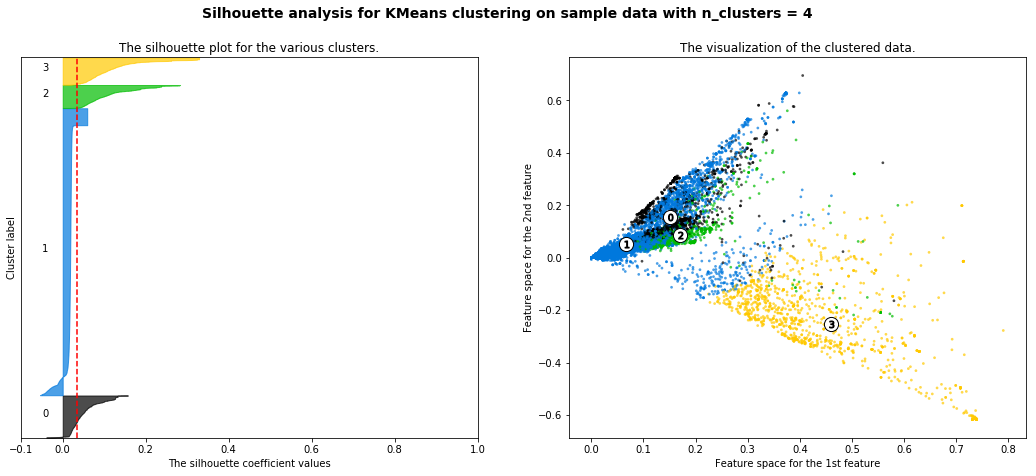

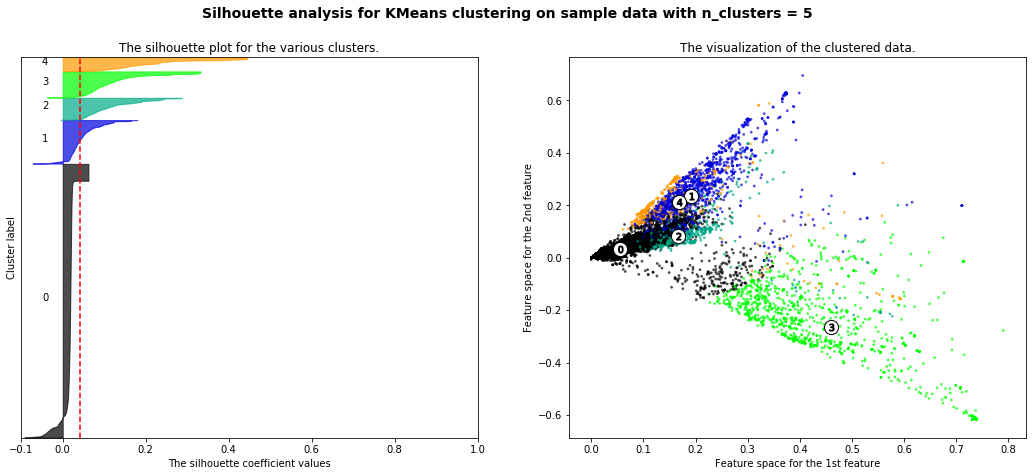

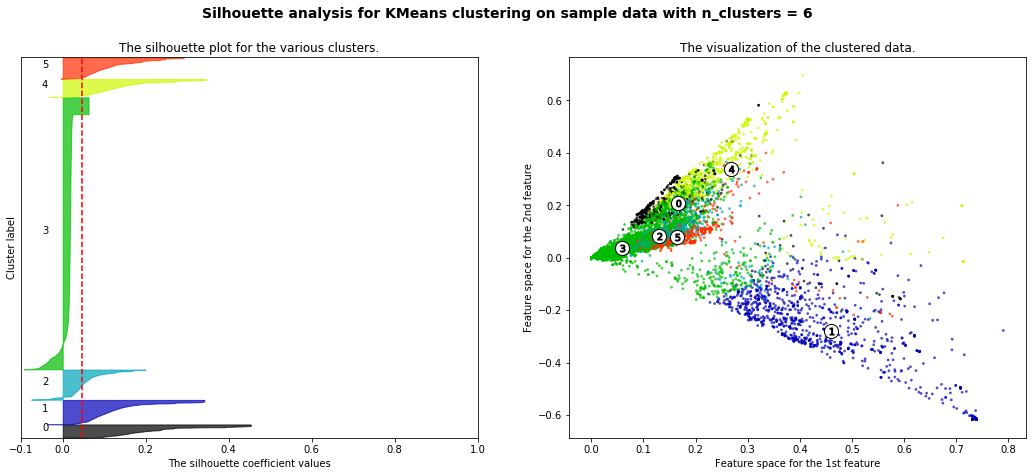

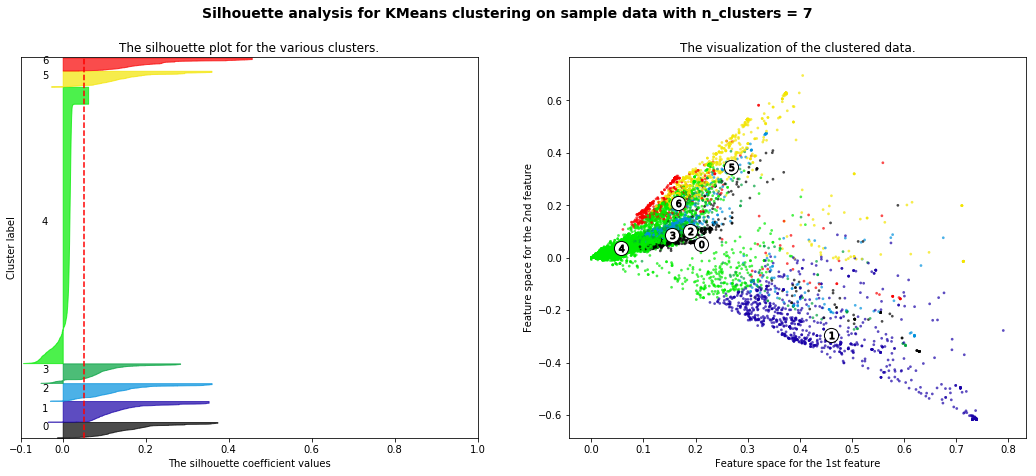

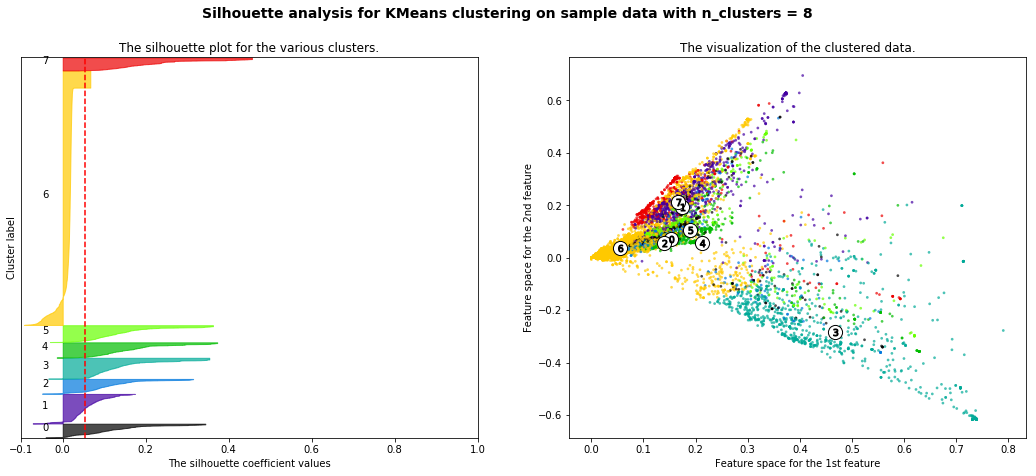

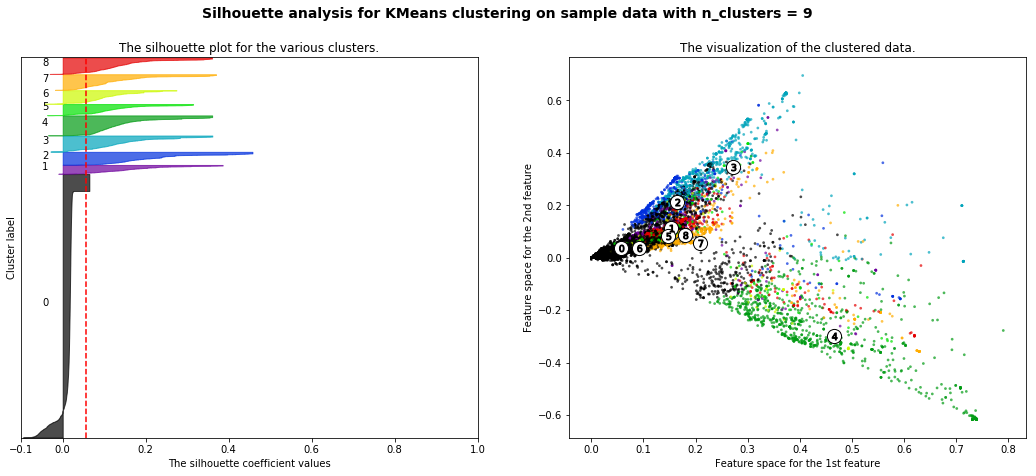

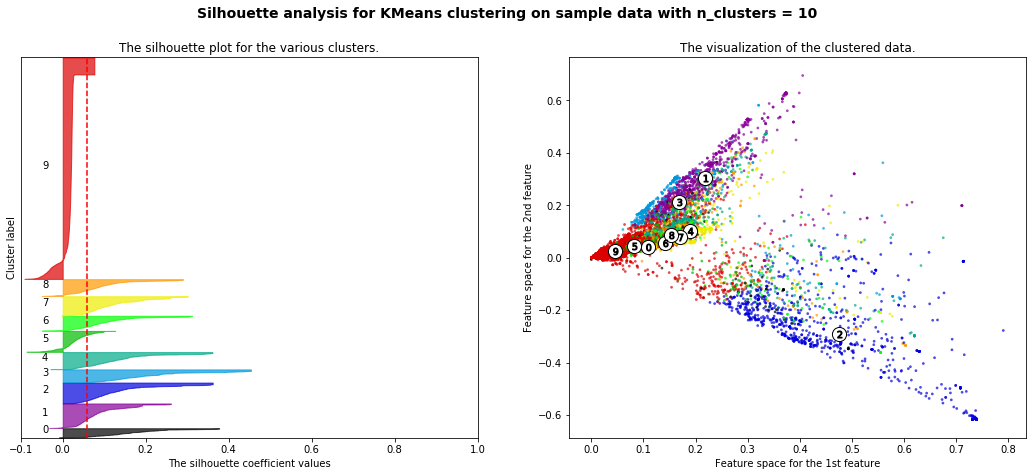

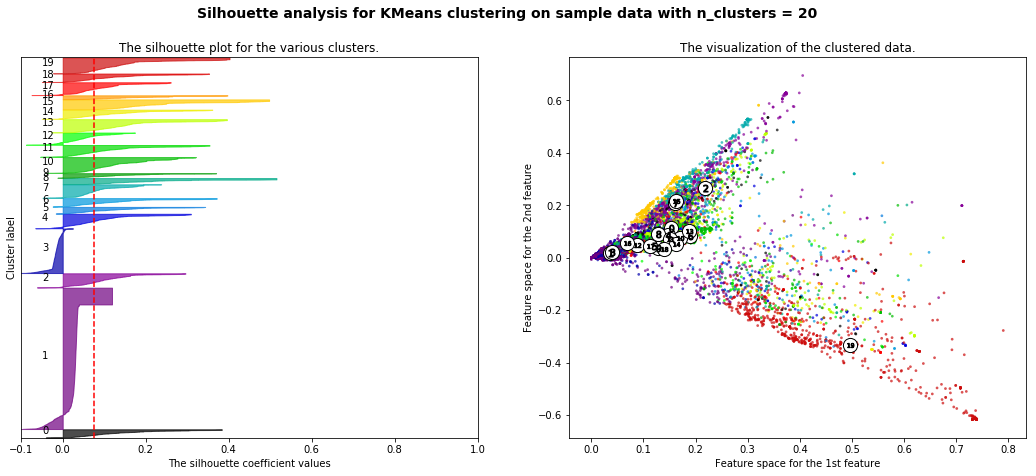

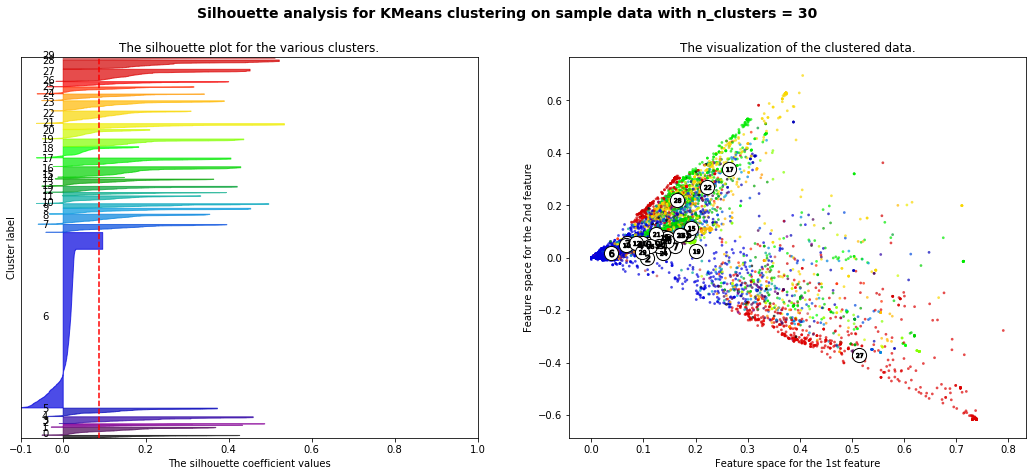

In [246]:
# Code from sklear documentation on silhouette scores
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
svd_norm=normalize(svd_df.iloc[:,1:201])

# Normalize the svd
X= normalize(svdn) # For reproducibility

range_n_clusters = [3,4,5,6,7,8,9, 10, 20, 30]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Silhouette scores around 0 indicate overlapping clusters. We can increase the silhoutte score marginally by using higher numbers of clusters. Sentences derived from songs can be very similar and as I stated before it is surprising to me that logistic regression can predict Dylan songs with an accuracy of ~75%. However, when modeling I did not try to predict other authors. As we can see in the plot of the two first svd components. actually, sentences from Dyland songs are clusters, where as others are not. So the results of the cluster evaluation is not as it first seemed contradictory but rather a valuable addition, indicating weakness in my previous analysis approach. 

# Similarity

Here I would like to understand, how different aspects of text features contribute to similarity. I will calculate a jaccard similarity matrix based on lemmatized text and a cosine vector similarity based on the latent semantics data (tfidf after svd). In order to keep tha data amount manageable, the following analysis will focus only on songa from Cher and Dylan.

In [40]:
# Helpful links
# Notes to measure the similarity betweenmatrixes
#https://stackoverflow.com/questions/35758612/most-efficient-way-to-construct-similarity-matrix

# Book rating in python, using knn to figure out similarity between customers
#https://towardsdatascience.com/my-journey-to-building-book-recommendation-system-5ec959c41847

# BEST article
#https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50

## Jaccard similarity between Dylan and Cher

Jaccard similarity or intersection over union is defined as size of intersection divided by size of union of two sets. Jaccard similarity is the size of intersection of the set divided by total size of set.(From: https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50)
### prepare lemma for jaccard

In [62]:
# Get the data
chosenartists= ['Bob Dylan', 'Cher']

DylanCher_df=df[df['artist'].isin(chosenartists)]

# Save the lemmas of each song text
Text_list= DylanCher_df.text.tolist()
print(len(Text_list))
lemma_list=[]
nlp = spacy.load('en')
for i in range(len(Text_list)):
    if i % 50 == 0:
            print("Processing row {}".format(i))
    text=Text_list[i]
    text_doc=nlp(text)
    text_lemma = [token.lemma_ for token in text_doc]
    lemma_list.append(text_lemma)

print(len(lemma_list))

375
Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250
Processing row 300
Processing row 350
375


### Calculate Jaccard similarity matrix

In [63]:
def get_jaccard_sim(str1, str2): 
    a = set(str1) 
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

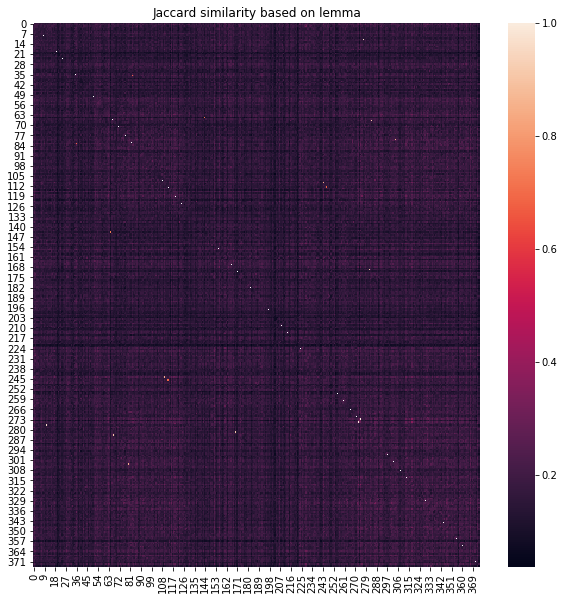

(375, 375)
375
Highest similarity observed: 1.0
      artist     song
27268   Cher  Believe
      artist                         song
27270   Cher  Believe (Club 69 Phunk Dub)

Lowest similarity observed: 0.038
      artist                                 song
27269   Cher  Believe (Club 69 Future Anthem Dub)
      artist                 song
27367   Cher  Miss Subway Of 1952


In [200]:
import itertools

jac_sim_matrix=np.zeros((len(lemma_list),len(lemma_list)))
index_list=range(len(lemma_list))

# Calculate the similarities
similarities=[]
for a, b in itertools.combinations(lemma_list, 2):
    similarities.append(get_jaccard_sim(a,b))

# determine the combinations
x_co=[]
y_co=[]
for a, b in itertools.combinations(index_list, 2):
    x_co.append(a)
    y_co.append(b)

# combine in a dataframe
sim_df=pd.DataFrame()
sim_df['sim']=similarities
sim_df['X']=x_co
sim_df['Y']=y_co

for i in range(len(similarities)):
    jac_sim_matrix[sim_df.X.iloc[i],sim_df.Y.iloc[i]]=sim_df.sim[i] # enter the similarity and [0,1]
    jac_sim_matrix[sim_df.Y.iloc[i],sim_df.X.iloc[i]]=sim_df.sim[i] # enter the similarity and [1,0]
    jac_sim_matrix[sim_df.X.iloc[i],sim_df.X.iloc[i]]=None # leave the diagonals blank
       
MAX=sim_df.sim.max()
MIN=sim_df.sim.min()

# Make the heatmap
plt.figure(figsize=(10,10))
sns.heatmap(jac_sim_matrix,vmin=MIN, vmax=MAX)
plt.title('Jaccard similarity based on lemma')
plt.show()

# Transform array to matrix
jac_sim_df=pd.DataFrame(data=jac_sim_matrix)
print(jac_sim_df.shape)

# prepare the labels for the columns and index
Artist_Song=[]
for i in range(375): 
    Artist_Song.append(DylanCher_df.artist.iloc[i]+'_'+DylanCher_df.song.iloc[i]) 
print(len(Artist_Song))

# Label the columns and index of the similarity matrix with Artist and Song
jac_sim_df.columns=Artist_Song
jac_sim_df.index=Artist_Song

print('Highest similarity observed:',round(MAX,3))
print(DylanCher_df[['artist','song']].iloc[sim_df['X'][sim_df.sim==MAX]])
print(DylanCher_df[['artist','song']].iloc[sim_df['Y'][sim_df.sim==MAX]])
print()
print('Lowest similarity observed:', round(MIN,3))
print(DylanCher_df[['artist','song']].iloc[sim_df['X'][sim_df.sim==MIN]])
print(DylanCher_df[['artist','song']].iloc[sim_df['Y'][sim_df.sim==MIN]])

Uh, clearly I should have removed duplicates in the songs. But Cher's song 'Believe' will serve as an excellent positive control. Next, to evaluate the similarity matrix, I will randomly pick a few songs and see what are the most similar songs to those. I will use 'Cher Believe' as positive control.

### Evaluating the similarity matrix

In [75]:
# Chose some texts
from operator import itemgetter 
listindeces = [273,9,22]

SongsForTest=itemgetter(*listindeces)(Artist_Song)

#iterate through text and return the top3 most similar hits
for song in SongsForTest:
    print("The three most similar songs to ", song, "are:")
    new_df=jac_sim_df.sort_values([song],ascending=False)
    output1="{top1s:s}\t{top1f:0.3f}" 
    print(output1.format(top1s=new_df.index[0], top1f=new_df[song].iloc[0]))
    output2="{top2s:s}\t{top2f:0.3f}" 
    print(output2.format(top2s=new_df.index[1], top2f=new_df[song].iloc[1]))
    output3="{top3s:s}\t{top3f:0.3f}\n" 
    print(output3.format(top3s=new_df.index[2], top3f=new_df[song].iloc[2]))
    print()

The three most similar songs to  Cher_Believe are:
Cher_Believe (Club 69 Phunk Dub)	1.000
Cher_Hard Enough Getting Over You	0.370
Cher_Believe (Club 69 Future Anthem Dub)	0.297


The three most similar songs to  Bob Dylan_Black Crow Blues are:
Cher_Don't Think Twice, It's All Right	0.255
Bob Dylan_Baby, Stop Crying	0.246
Bob Dylan_Don't Think Twice, It's All Right	0.244


The three most similar songs to  Bob Dylan_Clean-Cut Kid are:
Cher_Fire And Rain	0.206
Bob Dylan_I'd Hate To Be You On That Dreadful Day	0.202
Bob Dylan_Driftin' Too Far From Shore	0.202




## Cosine vector similarity based on tfidf-svd

Instead of calculating the tfidf values per sentence in a song, tfidf scores will be calculated per song, in order to answer the question which song is most similar to another.

### prepare the tfidf-svd

In [48]:
#data for tfidf
songtext_list=DylanCher_df['text'].tolist()
print(len(songtext_list))
type(songtext_list)

375


list

In [254]:
# calculate tfidf
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than 75% of all the paragraphs
                                min_df=4, # only use words that appear at 4 times
                                 stop_words='english', 
                                 lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                                 use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                                 norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                                 smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                                )


#Applying the vectorizer
text_paras_tfidf=vectorizer.fit_transform(songtext_list)
print("Number of features: %d" % text_paras_tfidf.get_shape()[1])

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(n_components=200)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
svd_lsa_features = lsa.fit_transform(text_paras_tfidf)
print("Number of features after svd:", svd_lsa_features.shape[1])

svd_lsa_df=pd.DataFrame(data=svd_lsa_features)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

results=pd.DataFrame()
results['svd']=range(200)
results['variance']= svd.explained_variance_ratio_
results=results.sort_values('variance',ascending=False)
results.head()

Number of features: 1186
Number of features after svd: 200
Percent variance captured by all components: 82.92333707129211


,svd,variance
1,1,0.014726
2,2,0.013499
3,3,0.012099
4,4,0.011180
5,5,0.010833


In [91]:
# convert in
from scipy.sparse import *
from scipy import *
svd_lsa_csr=csr_matrix( (svd_lsa_df.values), shape=(375,200) )
type(svd_lsa_csr)

scipy.sparse.csr.csr_matrix

### Calculate cosine similarity with tfidf-svd

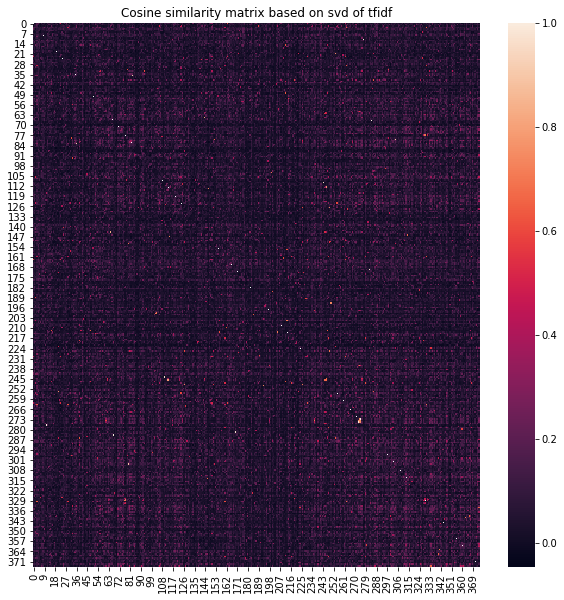

In [247]:
# Each entry in the song_docs list is a doc object corresponding to one song.
# Now compare the similarities between each song
import itertools

cosine_sim_matrix2=np.zeros((text_paras_tfidf.shape[0],text_paras_tfidf.shape[0]))
index_list=range(text_paras_tfidf.shape[0])

# Calculate the similarities
similarities2=[]
for a, b in itertools.combinations(svd_lsa_csr, 2):
    a_vec=a.toarray()
    #print(type(a))
    b_vec=b.toarray()
    similarities2.append(cosine_similarity(a_vec,b_vec))

#Need to flatten the similarity list, it contains nested arrays...so weird
flat_list=[]
for sublist in similarities2:
    for item in sublist:
        flat_list.append(item)

flat_list2=[]
for sublist in flat_list:
    for item in sublist:
        flat_list2.append(item)

# determine the combinations
x_co=[]
y_co=[]
for a, b in itertools.combinations(index_list, 2):
    x_co.append(a)
    y_co.append(b)

# combine in a dataframe
sim_df2=pd.DataFrame()
sim_df2['sim']=flat_list2
sim_df2['X']=x_co
sim_df2['Y']=y_co

MAX2=sim_df2.sim.max()
MIN2=sim_df2.sim.min()

for i in range(len(similarities)):
    cosine_sim_matrix2[sim_df2.X.iloc[i],sim_df2.Y.iloc[i]]=sim_df2.sim[i] # enter the similarity and [0,1]
    cosine_sim_matrix2[sim_df2.Y.iloc[i],sim_df2.X.iloc[i]]=sim_df2.sim[i] # enter the similarity and [1,0]
    cosine_sim_matrix2[sim_df2.X.iloc[i],sim_df2.X.iloc[i]]=None # leave the diagonals blank
    
plt.figure(figsize=(10,10))
sns.heatmap(cosine_sim_matrix2, vmin=MIN2,vmax=MAX2)
plt.title('Cosine similarity matrix based on svd of tfidf')
plt.show()

In [248]:
# Transform array to matrix
cos_sim_df=pd.DataFrame(data=cosine_sim_matrix2)
print(cos_sim_df.shape)

MAX2=sim_df2.sim.max()
MIN2=sim_df2.sim.min()

# prepare the labels for the columns and index
Artist_Song=[]
for i in range(375): 
    Artist_Song.append(DylanCher_df.artist.iloc[i]+'_'+DylanCher_df.song.iloc[i]) 
print(len(Artist_Song))

# Label the columns and index of the similarity matrix with Artist and Song
cos_sim_df.columns=Artist_Song
cos_sim_df.index=Artist_Song

print('Highest similarity observed:',round(MAX2,3))
print(DylanCher_df[['artist','song']].iloc[sim_df2['X'][sim_df2.sim==MAX2]])
print(DylanCher_df[['artist','song']].iloc[sim_df2['Y'][sim_df2.sim==MAX2]])
print()
print('Lowest similarity observed:', round(MIN2,3))
print(DylanCher_df[['artist','song']].iloc[sim_df2['X'][sim_df2.sim==MIN2]])
print(DylanCher_df[['artist','song']].iloc[sim_df2['Y'][sim_df2.sim==MIN2]])

(375, 375)
375
Highest similarity observed: 1.0
      artist     song
27268   Cher  Believe
      artist                         song
27270   Cher  Believe (Club 69 Phunk Dub)

Lowest similarity observed: -0.046
      artist        song
27312   Cher  Half Breed
      artist                              song
27315   Cher  He Ain't Heavy...He's My Brother


In [249]:
# Transform array to matrix
cosine_sim_df2=pd.DataFrame(data=cosine_sim_matrix2)
print(cosine_sim_df2.shape)

# prepare the labels for the columns and index
Artist_Song=[]
for i in range(375): 
    Artist_Song.append(DylanCher_df.artist.iloc[i]+'_'+DylanCher_df.song.iloc[i]) 
print(len(Artist_Song))

# Label the columns and index of the similarity matrix with Artist and Song
cosine_sim_df2.columns=Artist_Song
cosine_sim_df2.index=Artist_Song
# Chose some texts
from operator import itemgetter 
listindeces = [273,9,22]

SongsForTest=itemgetter(*listindeces)(Artist_Song)

#iterate through text and return the top3 most similar hits
for song in SongsForTest:
    print("The three most similar songs to ", song, "are:")
    new_df=cosine_sim_df2.sort_values([song],ascending=False)
    output1="{top1s:s}\t{top1f:0.3f}" 
    print(output1.format(top1s=new_df.index[0], top1f=new_df[song].iloc[0]))
    output2="{top2s:s}\t{top2f:0.3f}" 
    print(output2.format(top2s=new_df.index[1], top2f=new_df[song].iloc[1]))
    output3="{top3s:s}\t{top3f:0.3f}\n" 
    print(output3.format(top3s=new_df.index[2], top3f=new_df[song].iloc[2]))
    print()

(375, 375)
375
The three most similar songs to  Cher_Believe are:
Cher_Believe (Club 69 Phunk Dub)	1.000
Cher_Believe (Club 69 Future Anthem Dub)	0.744
Bob Dylan_I Believe In You	0.452


The three most similar songs to  Bob Dylan_Black Crow Blues are:
Cher_Knock On Wood	0.286
Cher_I Got You Babe	0.262
Bob Dylan_All Over You	0.261


The three most similar songs to  Bob Dylan_Clean-Cut Kid are:
Bob Dylan_In The Garden	0.404
Bob Dylan_I Shall Be Free	0.369
Bob Dylan_In The Summertime	0.317




## Spacy similarity

Spacy  determines similarity by comparing word vectors or "word embeddings", multi-dimensional meaning representations of a word. Word vectors can be generated using an algorithm like word2vec. This is probably not a good choice, because the input texts we are using are pretty big.

In [120]:
# Parse the songtexts using spacy tokenization. This can take a bit.
nlp = spacy.load('en')

song_docs=[]
# tokenize
for i, song in enumerate(DylanCher_df['text']):
    doc=nlp(song)
    song_docs.append(doc)

### Calculate spacy similarity

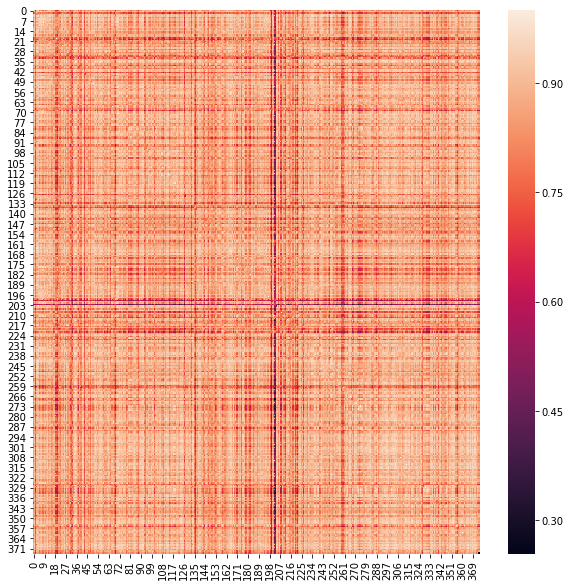

In [121]:
# Each entry in the song_docs list is a doc object corresponding to one song.
# Now compare the similarities between each song
import itertools

spacy_sim_matrix=np.zeros((len(song_docs),len(song_docs)))
index_list=range(len(song_docs))

# Calculate the similarities
similarities=[]
for a, b in itertools.combinations(song_docs, 2):
    similarities.append(a.similarity(b))

# determine the combinations
x_co=[]
y_co=[]
for a, b in itertools.combinations(index_list, 2):
    x_co.append(a)
    y_co.append(b)

# combine in a dataframe
sim_df3=pd.DataFrame()
sim_df3['sim']=similarities
sim_df3['X']=x_co
sim_df3['Y']=y_co

for i in range(len(similarities)):
    spacy_sim_matrix[sim_df3.X.iloc[i],sim_df3.Y.iloc[i]]=sim_df3.sim[i] # enter the similarity and [0,1]
    spacy_sim_matrix[sim_df3.Y.iloc[i],sim_df3.X.iloc[i]]=sim_df3.sim[i] # enter the similarity and [1,0]
    spacy_sim_matrix[sim_df3.X.iloc[i],sim_df3.X.iloc[i]]=None # leave the diagonals blank
 
MAX3=sim_df3.sim.max()
MIN3=sim_df3.sim.min()

plt.figure(figsize=(10,10))
sns.heatmap(spacy_sim_matrix, vmax=MAX3, vmin=MIN3)
plt.show()

### Evaluating the similarity matrix

In [122]:
# Which song is most similar to those songs:
# Transform array to matrix
spacy_sim_df=pd.DataFrame(data=spacy_sim_matrix)
print(spacy_sim_df.shape)

# prepare the labels for the columns and index
Artist_Song=[]
for i in range(375): 
    Artist_Song.append(DylanCher_df.artist.iloc[i]+'_'+DylanCher_df.song.iloc[i]) 
print(len(Artist_Song))

# Label the columns and index of the similarity matrix with Artist and Song
spacy_sim_df.columns=Artist_Song
spacy_sim_df.index=Artist_Song

# Chose some texts
from operator import itemgetter 
listindeces = [273,9,22]

SongsForTest=itemgetter(*listindeces)(Artist_Song)

#iterate through text and return the top3 most similar hits
for song in SongsForTest:
    print("The three most similar songs to ", song, "are:")
    new_df=spacy_sim_df.sort_values([song],ascending=False)
    output1="{top1s:s}\t{top1f:0.3f}" 
    print(output1.format(top1s=new_df.index[0], top1f=new_df[song].iloc[0]))
    output2="{top2s:s}\t{top2f:0.3f}" 
    print(output2.format(top2s=new_df.index[1], top2f=new_df[song].iloc[1]))
    output3="{top3s:s}\t{top3f:0.3f}\n" 
    print(output3.format(top3s=new_df.index[2], top3f=new_df[song].iloc[2]))
    print()

(375, 375)
375
The three most similar songs to  Cher_Believe are:
Cher_Believe (Club 69 Phunk Dub)	1.000
Cher_I Don't Have To Sleep To Dream	0.971
Cher_I Hate To Sleep Alone	0.965


The three most similar songs to  Bob Dylan_Black Crow Blues are:
Bob Dylan_Bob Dylan's New Orleans Rag	0.968
Bob Dylan_Down The Highway	0.964
Bob Dylan_Boots Of Spanish Leather	0.963


The three most similar songs to  Bob Dylan_Clean-Cut Kid are:
Bob Dylan_Bob Dylan's 115Th Dream	0.952
Bob Dylan_Isis	0.934
Bob Dylan_In The Summertime	0.934




## Results
Both Jaccard which uses a lemma matrix and cosine vector similarity based on the tfidf-svd data correctly detects the duplicates of Cher's song 'Believe'. However, for both other songs, Jaccard and cosine vector similarity return different results. Neither one is wrong or right, because they both depend on unique measurements. Basically, as if we would compare shapes of different color: Based on color the dark green square is more similar to the green circle. But based on the shape it is more similar to the orange recangle. <br>  
As expected, the similarity based on word2vec (here: Spacy similarity) even fails to detect the duplicates of Cher's song 'Believe'. Word-embeddings are more appropriate for shorter texts.

# Do the songs cluster by author?

As we have seen in the previous experiment (7. Do the sentences cluster by author?), the tfidf-svd does not show that the individual songs cluster by author. But what if we use the whole texts?

In [258]:
# Plot the svd data
# Make a new df to store the new features
#lsa_df=pd.DataFrame(data=svd_lsa_csr)

# Add columns names
n_lsa=svd_lsa_df.shape[1]

columnsN=[]
for i in range(n_lsa):
    columnsN.append('lsa_'+str(i+1))

svd_lsa_df.columns=columnsN
svd_lsa_df.head()

artists=DylanCher_df.artist.tolist()
songs= DylanCher_df.song.tolist()

svd_lsa_df['Artist']=artists
svd_lsa_df['Song']=songs

# Make the plot
expVar12=round((results.variance.iloc[0]+results.variance.iloc[1])*100,3)
Title='Around '+ str(expVar12) +'% variance explained through lsa1 and lsa2'
(ggplot(svd_lsa_df)
 + geom_point(aes(x='lsa_1', y='lsa_2', color='Artist'))
 + labs(title=Title)
)

200

For n_clusters = 2 The average silhouette_score is : 0.008431372031624204
For n_clusters = 3 The average silhouette_score is : 0.006595545601817795
For n_clusters = 4 The average silhouette_score is : 0.007873500277152091
For n_clusters = 5 The average silhouette_score is : 0.008478417245887427


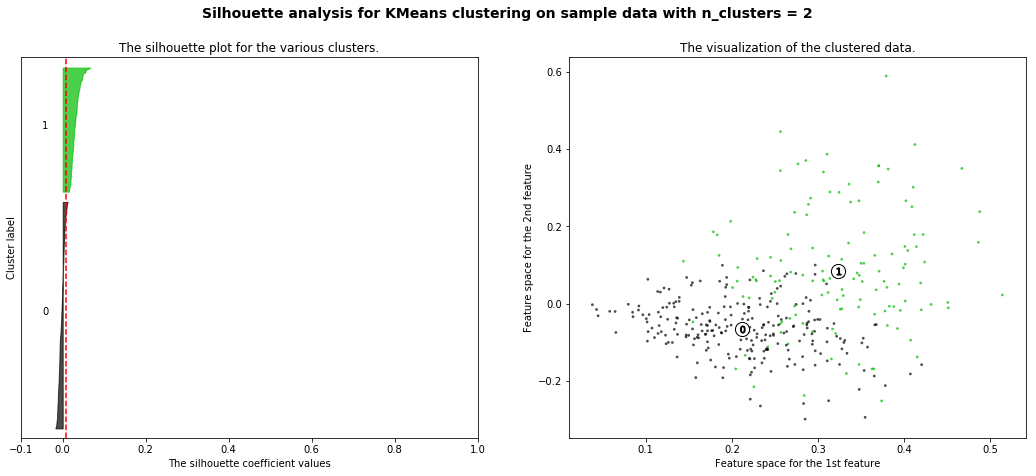

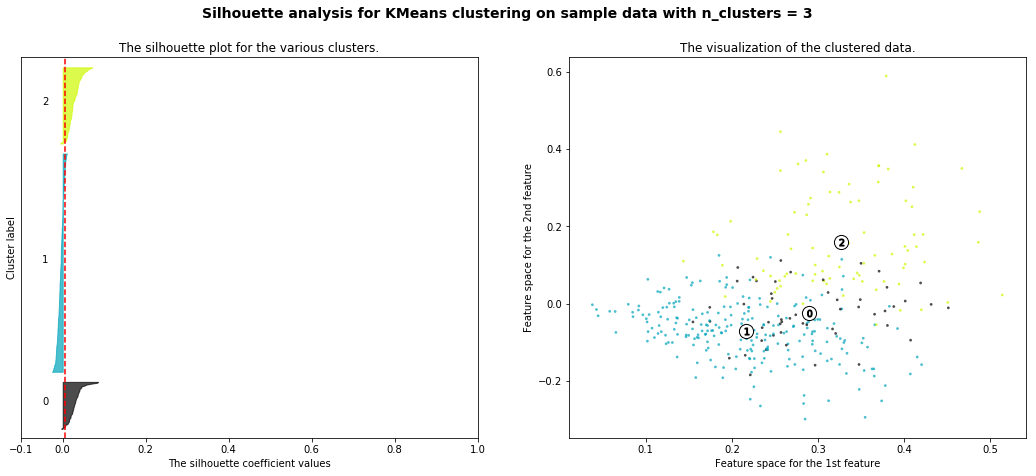

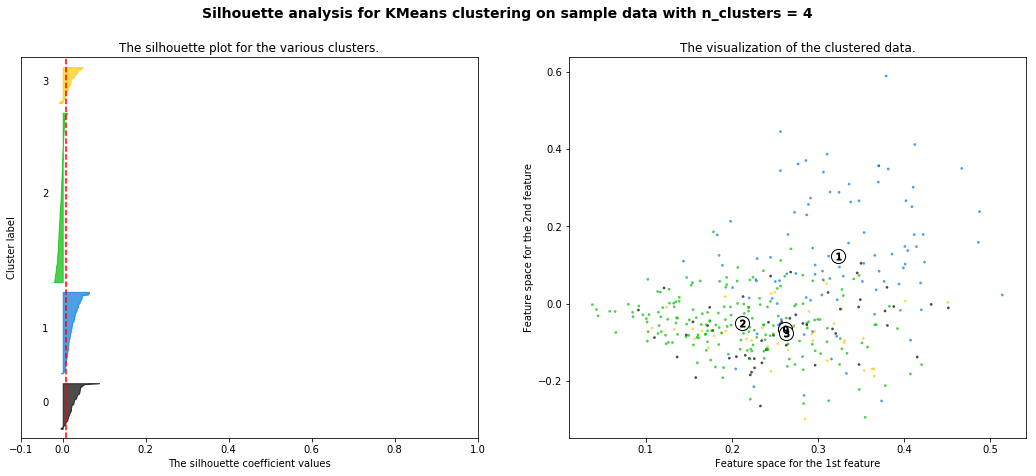

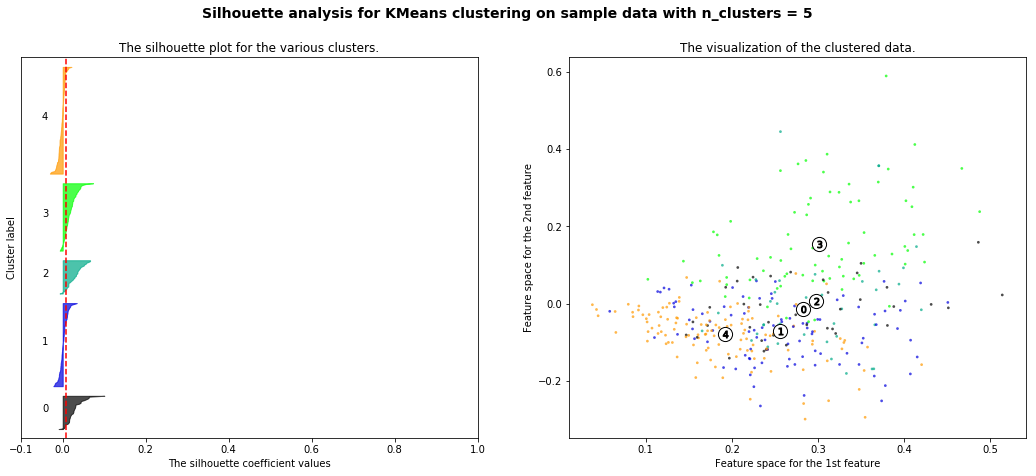

In [271]:
# try different amounts of clusters and plot the solhoutte scores for 
svd_norm=normalize(svd_lsa_df.iloc[:,0:200])

X= normalize(svd_norm) # For reproducibility

range_n_clusters = [2,3,4,5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The individual songs texts overlap similarly to the individual sentences, this can be seen both in the svd-component plot, as well as in the silhouette scores which are again close to 0. 